# Goal

Let's use an export of [Paul's blog](https://paulbricman.com/reflections) to predict his stance towards 63 statements designed to elicit values about polarizing topics.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get list of all paragraphs used in the blog.
import os
from nltk import sent_tokenize

paragraphs = []
for filename in os.listdir('../data/blog/'):
    with open('../data/blog/' + filename, 'r') as f:
        blog = f.read().split('\n\n')[1:]
        blog = [e for e in blog if len(sent_tokenize(e)) > 2]
        paragraphs.extend(blog)

print(*paragraphs[:3], sep='\n\n')

Some discussions I've had this past week reminded me of a certain challenge faced by personal knowledge management solutions, in the more general sense of Zettelkasten, digital gardens, and second brains, rather than Obsidian, Roam, and Logseq. I should mention, however, that not many people I know see this as a problem, so it might only be a pet peeve of sorts. The issue I'm referring to is the fact that many PKM solutions make it easy to find ideas you're specifically looking for, but don't make much progress in helping you find ideas you didn't even know you were looking for. They make it easy to index notes in such a way as to find them easily later on, to act as a librarian or cartographer of knowledge, but don't help you as much as I'd like to in finding truly unexpected solutions and connections. The nuance is pretty subtle, so it might not make complete sense yet. The rest of this article explains in more depth what this contrast feels like, why I think open-ended search is a v

In [3]:
# Get polarizing statements and personal valuations (not synced with github)
import pandas as pd

df = pd.read_csv('~/Downloads/valuations.csv')

In [4]:
from sentence_transformers import CrossEncoder, SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM

emb_model = SentenceTransformer('all-MiniLM-L6-v2')
nli_model = CrossEncoder('cross-encoder/nli-deberta-v3-base')
lm_model = AutoModelForCausalLM.from_pretrained('distilgpt2')
lm_tok = AutoTokenizer.from_pretrained('distilgpt2')

In [19]:
from src.baselines import infer_embs, infer_nli
from src.abduction import infer

aggregate_emb = []
aggregate_nli_absolute = []
aggregate_nli_relative = []
aggregate_lm = []

for idx, row in df.head(2).iterrows():
    emb_probs = []
    nli_absolute_probs = []
    nli_relative_probs = []
    lm_probs = []

    for paragraph in paragraphs[:2]:
        emb_probs += [infer_embs(paragraph, [row['statement'], row['negation']], encoder=emb_model)[0]]
        nli_absolute_probs += [infer_nli(paragraph, [row['statement']], mode='absolute')[0]]
        nli_relative_probs += [infer_nli(paragraph, [row['statement'], row['negation']], mode='relative')[0]]
        lm_probs += [infer(paragraph, [row['statement'], row['negation']], model=lm_model, tokenizer=lm_tok)[0]]

    aggregate_emb += [emb_probs]
    aggregate_nli_absolute += [nli_absolute_probs]
    aggregate_nli_relative += [nli_relative_probs]
    aggregate_lm += [lm_probs]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


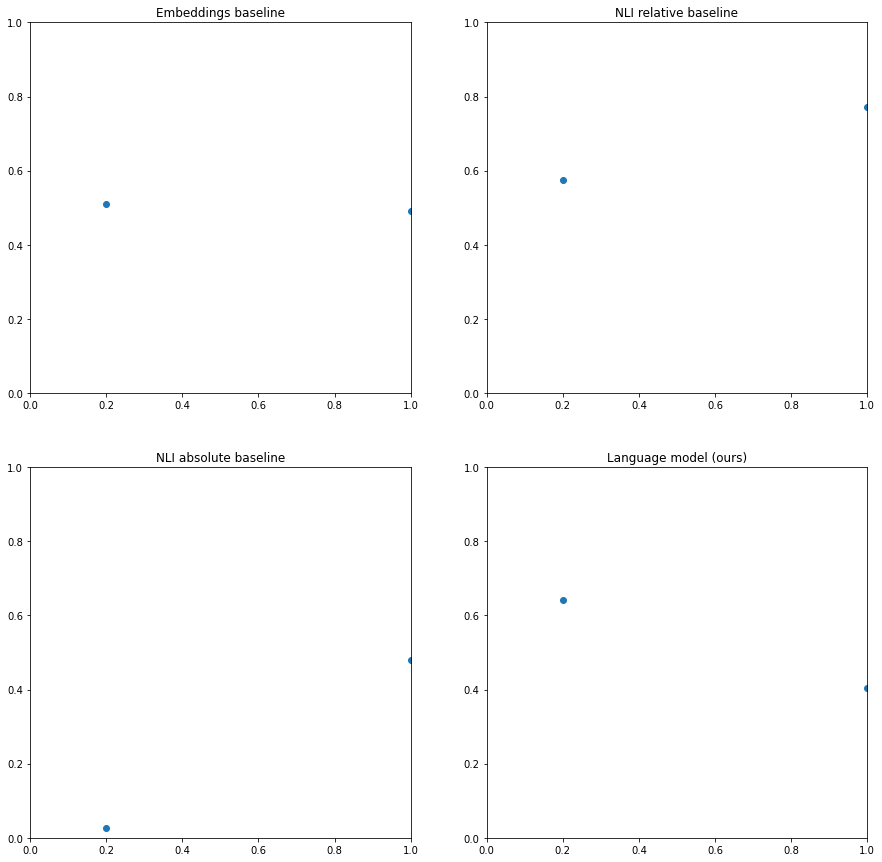

In [30]:
# Plot correlations with valuations
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Embeddings baseline')
plt.scatter(df['score'].values[:2], [np.mean(e) for e in aggregate_emb])

plt.subplot(2, 2, 2)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('NLI relative baseline')
plt.scatter(df['score'].values[:2], [np.mean(e) for e in aggregate_nli_relative])

plt.subplot(2, 2, 3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('NLI absolute baseline')
plt.scatter(df['score'].values[:2], [np.mean(e) for e in aggregate_nli_absolute])

plt.subplot(2, 2, 4)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Language model (ours)')
plt.scatter(df['score'].values[:2], [np.mean(e) for e in aggregate_lm])